In [1]:
import os 
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.interpolate import interp1d

from sktime.regression.deep_learning import CNNRegressor
from sktime.forecasting.model_selection import temporal_train_test_split
from statsmodels.tsa.vector_ar.var_model import VAR
from math import sqrt

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.kernel_based import RocketClassifier

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.inspection import (partial_dependence, PartialDependenceDisplay, permutation_importance)
from sklearn import preprocessing, datasets, ensemble, model_selection
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# Criação de dataset unificado

In [2]:
data_set_path = r"C:\Users\luiza\Documents\UFSC\TCC_Datasets\WESAD\WESAD"


In [3]:
# Lista para armazenar os dados combinados de todos os diretórios
all_data = []

# Lista de diretórios de S2 a S17
folders = [f"S{i}" for i in range(2, 18)]

for folder_name in folders:
    folder_path = os.path.join(data_set_path, folder_name)

    if os.path.exists(folder_path):
        for folder in os.listdir(folder_path):
            if folder.endswith(".pkl"):
                caminho_arquivo_pkl = os.path.join(folder_path, folder)
                
                # Abrir o arquivo .pkl
                with open(caminho_arquivo_pkl, 'rb') as infile:
                    obj = pickle.load(infile, encoding='latin1')
                    bvp=obj['signal']['wrist']['BVP'][:,0]
                    eda=obj['signal']['wrist']['EDA'][:,0]
                    temp=obj['signal']['wrist']['TEMP'][:,0]
                    label=obj['label']



In [4]:
fs_label = 700  # Hz
fs_temp_eda = 4  # Hz
fs_bvp = 64  # Hz

len_label = len(label)
len_temp_eda = len(temp)
len_bvp = len(bvp)

total_time = len_label / fs_label

time_label = np.linspace(0, total_time, len_label, endpoint=False)
time_temp_eda = np.linspace(0, total_time, len_temp_eda, endpoint=False)
time_bvp = np.linspace(0, total_time, len_bvp, endpoint=False)


interp_temp = interp1d(time_temp_eda, temp, kind='nearest', fill_value='extrapolate')
interp_eda = interp1d(time_temp_eda, eda, kind='nearest', fill_value='extrapolate')
interp_bvp = interp1d(time_bvp, bvp, kind='nearest', fill_value='extrapolate')

aligned_temp = interp_temp(time_label)
aligned_eda = interp_eda(time_label)
aligned_bvp = interp_bvp(time_label)

In [5]:
hr_data = []
folders = [f"S{i}" for i in range(2, 18)]


for folder_name in folders:
    subfolder_name = f"{folder_name}_E4_Data"
    folder_path = os.path.join(data_set_path, folder_name, subfolder_name)

    if os.path.exists(folder_path):
        csv_path = os.path.join(folder_path, 'HR.csv')
        if os.path.exists(csv_path):
            hr = pd.read_csv(csv_path, skiprows=2, usecols=[0], header=None)
            hr_data.append(hr)

if hr_data:
    combined_hr_df = pd.concat(hr_data, ignore_index=True)
    # Converte para numpy array
    hr = combined_hr_df.iloc[:, 0].to_numpy()

fs_hr = 1  # Hz
len_hr = len(hr)
time_hr = np.linspace(0, total_time, len_hr, endpoint=False)
interp_hr = interp1d(time_hr, hr, kind='nearest', fill_value='extrapolate')
aligned_hr = interp_hr(time_label)

In [ ]:
numpy_data = np.column_stack((aligned_bvp, aligned_hr, aligned_eda, aligned_temp, label))
all_data.append(numpy_data)
combined_data = np.concatenate(all_data, axis=0)
column_names = ["bvp", "hr", "eda", "temp", "label"]
df = pd.DataFrame(data=combined_data, columns=column_names)


# 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset 
df = df[df['label'] != 7.0]
df= df[df['label'] != 6.0]
df= df[df['label'] != 5.0]
df = df.drop_duplicates()

### NORMALIZAR E CRIAR MIN, MEAN, MAX

In [ ]:
def calculate_and_normalize_stats(df, column):
    min_vals, max_vals, mean_vals = [], [], []
    for i in range(0, len(df), 3):
        vals = df[column].iloc[i:i+3]
        min_vals.append(vals.min())
        max_vals.append(vals.max())
        mean_vals.append(vals.mean())
    stats_df = pd.DataFrame({f'{column}_min': min_vals, f'{column}_max': max_vals, f'{column}_mean': mean_vals})
    normalized_mean = preprocessing.normalize([stats_df[f'{column}_mean'].to_numpy()]).flatten()
    normalized_max = preprocessing.normalize([stats_df[f'{column}_max'].to_numpy()]).flatten()
    normalized_min = preprocessing.normalize([stats_df[f'{column}_min'].to_numpy()]).flatten()
    return pd.DataFrame({f'normalized_{column}_mean': normalized_mean,
                        f'normalized_{column}_max': normalized_max,
                        f'normalized_{column}_min': normalized_min})

df_temp = calculate_and_normalize_stats(df, 'temp')
df_eda = calculate_and_normalize_stats(df, 'eda')
df_hr = calculate_and_normalize_stats(df, 'hr')


df_normalizado = pd.concat([df_temp, df_eda, df_hr], axis=1)
df_normalizado.tail()

,normalized_temp_mean,normalized_temp_max,normalized_temp_min,normalized_eda_mean,normalized_eda_max,normalized_eda_min,normalized_hr_mean,normalized_hr_max,normalized_hr_min
158904,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002401,0.002400,0.002402
158905,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002394,0.002400,0.002391
158906,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002390,0.002389,0.002391
158907,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002378,0.002376,0.002379
158908,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002378,0.002376,0.002379


In [8]:
label_mean = []
for i in range(0, len(df), 3):
    label = df['label'].iloc[i:i+3] 
    label_mean.append(label.mean())

label_stats = pd.DataFrame({'label_mean': label_mean})

# Aplicando algoritmos de classificação

In [9]:
train_set = df_normalizado
labels = np.array(label_stats, dtype=int)
X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.3, random_state=30)

In [10]:
if len(y_train.shape) > 1:
    y_train = y_train.flatten()
y_train_series = pd.Series(y_train)
y_train_series.value_counts()

0    53132
1    22752
4    14144
2    13996
3     7212
dtype: int64

### knn

In [11]:
k_nearest_neighbors = KNeighborsClassifier(n_neighbors=5, metric="minkowski", weights="uniform")
k_nearest_neighbors.fit(X_train, y_train.ravel())
y_pred_knn = k_nearest_neighbors.predict(X_test)
f1score_knn = f1_score(y_test, y_pred_knn, average='macro')
recall_knn = recall_score(y_test, y_pred_knn, average='macro')
accuracy_knn = accuracy_score(y_test, y_pred_knn)
AUC_knn = roc_auc_score(y_test.ravel(), k_nearest_neighbors.predict_proba(X_test), multi_class='ovr')

print('KNN - auc =', AUC_knn)
print('KNN - acc =', accuracy_knn)
print('KNN - f1 =', f1score_knn)
print('KNN - recall =', recall_knn)

KNN - auc = 0.991591047189687
KNN - acc = 0.9490067753235584
KNN - f1 = 0.9442958738494482
KNN - recall = 0.9461815087771754


### Logistic Regression

In [12]:
logistic_regression = LogisticRegression(penalty="l2", C=1.0, max_iter=999)
logistic_regression.fit(X_train, y_train.ravel())

y_pred_lr = logistic_regression.predict(X_test)
f1score_lr = f1_score(y_test, y_pred_lr, average='macro')
recall_lr = recall_score(y_test, y_pred_lr, average='macro')
accuracy_lr = accuracy_score(y_test, y_pred_lr)
AUC_lr = roc_auc_score(y_test.ravel(), logistic_regression.predict_proba(X_test), multi_class='ovr')

print('LR - auc =', AUC_lr)
print('LR - acc =', accuracy_lr)
print('LR - f1 =', f1score_lr)
print('LR - recall =', recall_lr)

LR - auc = 0.7752635523657919
LR - acc = 0.47582489039917775
LR - f1 = 0.12896513495458875
LR - recall = 0.2


### RF

In [13]:
clf = RandomForestClassifier(n_estimators=100,max_depth=15)
clf.fit(X_train, y_train.ravel())
y_pred_rf = clf.predict(X_test)

f1score_rf = f1_score(y_test, y_pred_rf, average='macro')
recall_rf = recall_score(y_test, y_pred_rf, average='macro')
accuracy_rf = accuracy_score(y_test, y_pred_rf)
AUC_rf = roc_auc_score(y_test.ravel(), clf.predict_proba(X_test), multi_class='ovr')

print('RF - auc =', AUC_rf)
print('RF - acc =', accuracy_rf)
print('RF - f1 =', f1score_rf)
print('RF - recall =', recall_rf)

RF - auc = 0.9995815756742866
RF - acc = 0.9836804900048245
RF - f1 = 0.9824265689617846
RF - recall = 0.9841872807171809


### neural network

In [14]:
neural_network = MLPClassifier(hidden_layer_sizes=(100,), activation="relu", solver="adam", max_iter=999)

neural_network.fit(X_train, y_train.ravel())

y_pred_nn = neural_network.predict(X_test)
f1score_nn = f1_score(y_test, y_pred_nn, average='macro')
recall_nn = recall_score(y_test, y_pred_nn, average='macro')
accuracy_nn = accuracy_score(y_test, y_pred_nn)
AUC_nn = roc_auc_score(y_test.ravel(), neural_network.predict_proba(X_test), multi_class='ovr')

print('NN - auc =', AUC_nn)
print('NN - acc =', accuracy_nn)
print('NN - f1 =', f1score_nn)
print('NN - recall =', recall_nn)

NN - auc = 0.9272463660221938
NN - acc = 0.7060180815136451
NN - f1 = 0.5566303498907166
NN - recall = 0.5379734891825212


C:\Users\luiza\AppData\Roaming\Python\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
  warnings.warn(


### SVM

In [15]:
support_vector_machine = SVC(C=1.0, gamma=0.1, kernel="linear", tol=0.001, max_iter=9999, probability=True)
support_vector_machine.fit(X_train, y_train.ravel())
y_pred_svm = support_vector_machine.predict(X_test)

f1score_svm = f1_score(y_test, y_pred_svm, average='macro')
recall_svm = recall_score(y_test, y_pred_svm, average='macro')
accuracy_svm = accuracy_score(y_test, y_pred_svm)
AUC_svm = roc_auc_score(y_test.ravel(), support_vector_machine.predict_proba(X_test), multi_class='ovr')

print('SVM - auc =', AUC_svm)
print('SVM - acc =', accuracy_svm)
print('SVM - f1 =', f1score_svm)
print('SVM - recall =', recall_svm)

C:\Users\luiza\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=9999).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM - auc = 0.8215606042036099
SVM - acc = 0.3615044154972416
SVM - f1 = 0.2956723635708373
SVM - recall = 0.3939929898922237


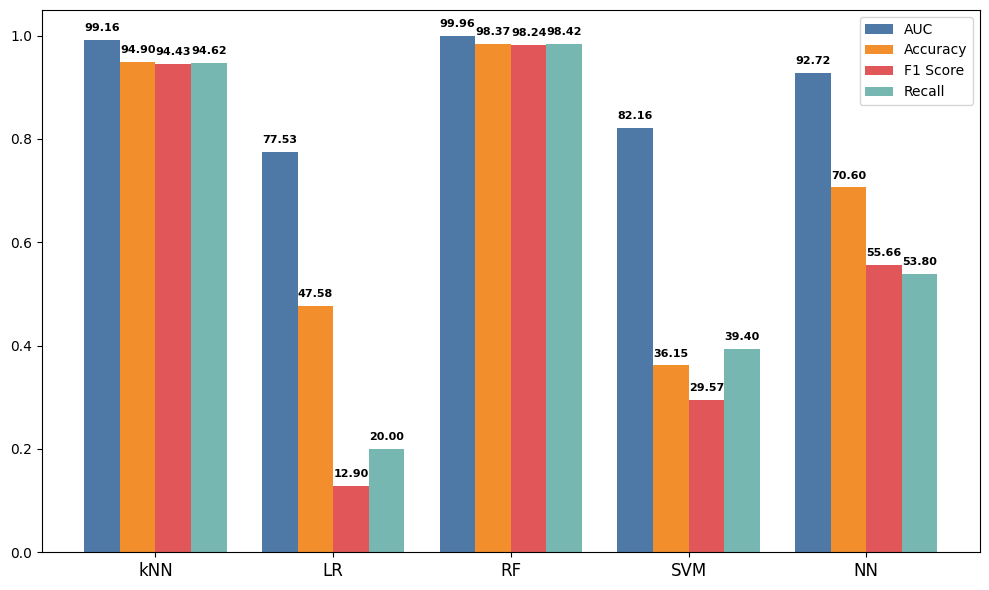

In [ ]:
labels = ['kNN', 'LR', 'RF', 'SVM', 'NN']
auc_scores = [AUC_knn, AUC_lr, AUC_rf, AUC_svm, AUC_nn]
accuracy_scores = [accuracy_knn, accuracy_lr, accuracy_rf, accuracy_svm, accuracy_nn]
f1_scores = [f1score_knn, f1score_lr, f1score_rf, f1score_svm, f1score_nn]
recall_scores = [recall_knn, recall_lr, recall_rf, recall_svm, recall_nn]

colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2']

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(labels))
width = 0.2  


bars1 = ax.bar(x - 1.5*width, auc_scores, width, label='AUC', color=colors[0])
bars2 = ax.bar(x - 0.5*width, accuracy_scores, width, label='Accuracy', color=colors[1])
bars3 = ax.bar(x + 0.5*width, f1_scores, width, label='F1 Score', color=colors[2])
bars4 = ax.bar(x + 1.5*width, recall_scores, width, label='Recall', color=colors[3])


def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height*100:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5), 
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8, fontweight='bold')


for bars in [bars1, bars2, bars3, bars4]:
    add_labels(bars)

ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend()

plt.tight_layout()
plt.show()



### feature importance

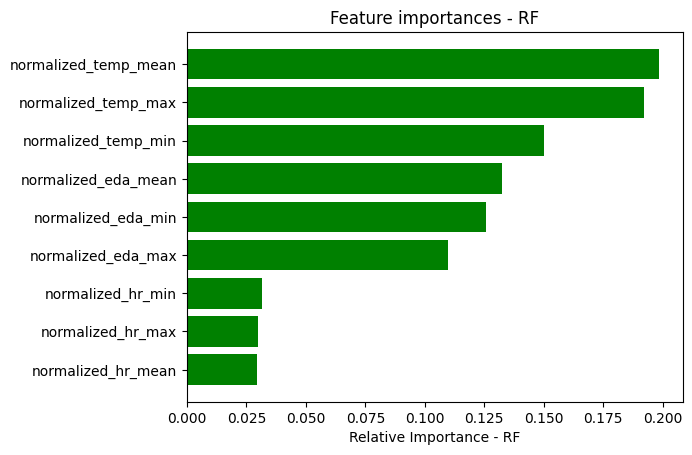

In [17]:
# -- feature importance graph
importances = clf.feature_importances_
indices = np.argsort(importances)
features = train_set.columns
plt.title('Feature importances - RF')
j = 9   # top j importance
plt.barh(range(j), importances[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Relative Importance - RF')
plt.show()

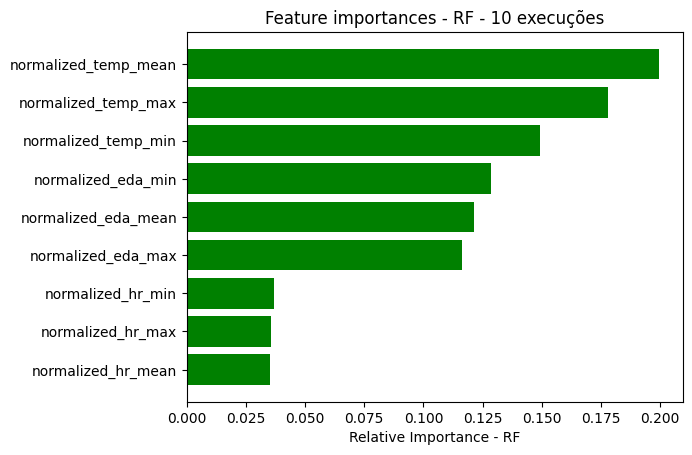

In [18]:
num_execucoes = 10
importancias_medias = np.zeros(X_train.shape[1])  # Lista para armazenar as importâncias médias das características

for _ in range(num_execucoes):
    clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=None) 
    clf.fit(X_train, y_train.ravel()) 
    
    importancias = clf.feature_importances_
    importancias_medias += importancias

importancias_medias /= num_execucoes # Calcular a média das importâncias das características

indices = np.argsort(importancias_medias)
plt.title('Feature importances - RF - 10 execuções')
j = 9   # top j importância
plt.barh(range(j), importancias_medias[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Relative Importance - RF')
plt.show()

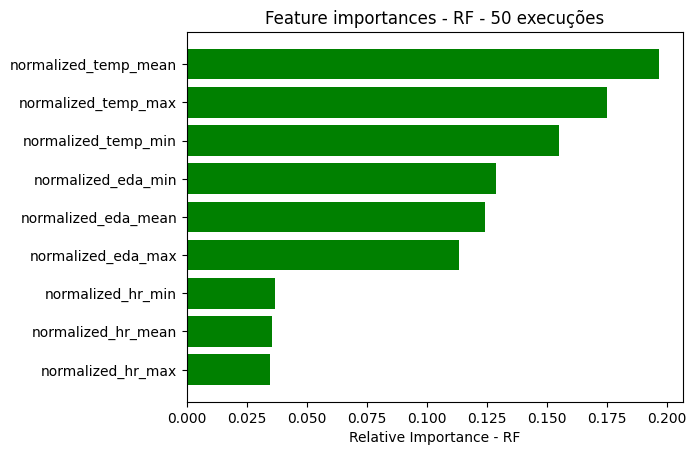

In [19]:
num_execucoes = 50
importancias_medias = np.zeros(X_train.shape[1])  # Lista para armazenar as importâncias médias das características

for _ in range(num_execucoes):
    clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=None) 
    clf.fit(X_train, y_train.ravel()) 
    
    importancias = clf.feature_importances_
    importancias_medias += importancias

importancias_medias /= num_execucoes # Calcular a média das importâncias das características

indices = np.argsort(importancias_medias)
plt.title('Feature importances - RF - 50 execuções')
j = 9   # top j importância
plt.barh(range(j), importancias_medias[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Relative Importance - RF')
plt.show()

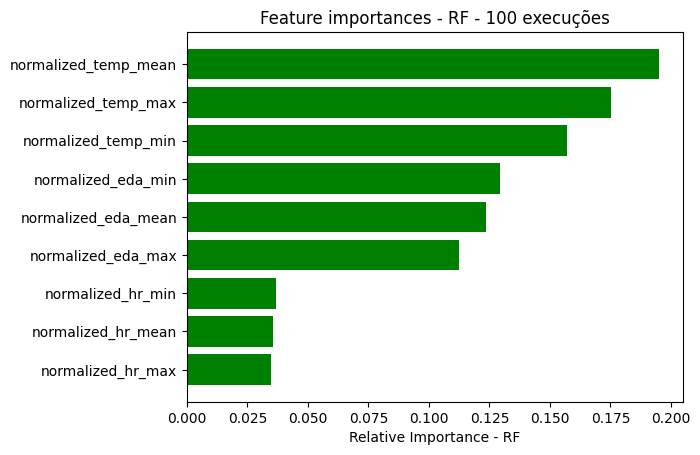

In [20]:
num_execucoes = 100
importancias_medias = np.zeros(X_train.shape[1])  # Lista para armazenar as importâncias médias das características

for _ in range(num_execucoes):
    clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=None) 
    clf.fit(X_train, y_train.ravel()) 
    
    importancias = clf.feature_importances_
    importancias_medias += importancias

importancias_medias /= num_execucoes # Calcular a média das importâncias das características

indices = np.argsort(importancias_medias)
plt.title('Feature importances - RF - 100 execuções')
j = 9   # top j importância
plt.barh(range(j), importancias_medias[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Relative Importance - RF')
plt.show()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


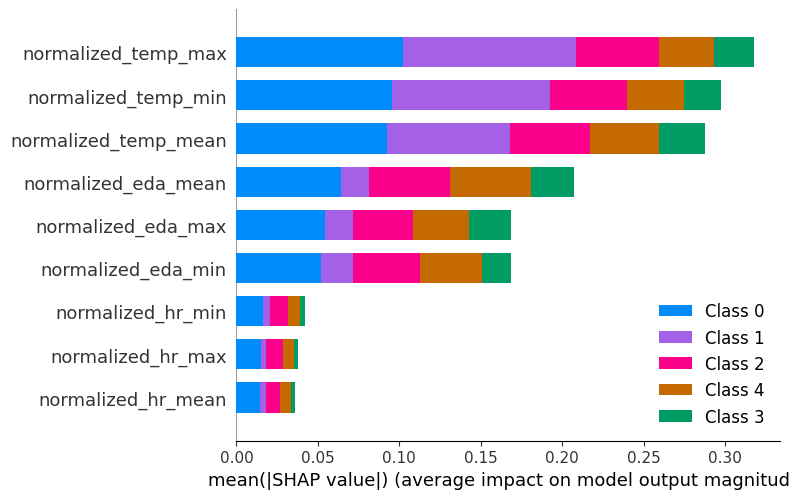

In [21]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type='bar')

# Criação de datasets individuais

In [22]:
dfs = {}
folders = [f"S{i}" for i in range(2, 18)]

for folder_name in folders:
    folder_path = os.path.join(data_set_path, folder_name)
    
    user_data = []

    if os.path.exists(folder_path):
        for folder in os.listdir(folder_path):
            if folder.endswith(".pkl"):
                caminho_arquivo_pkl = os.path.join(folder_path, folder)
                
                # Abrir o arquivo .pkl
                with open(caminho_arquivo_pkl, 'rb') as infile:
                    obj = pickle.load(infile, encoding='latin1')
                    eda = obj['signal']['wrist']['EDA'][:, 0]
                    temp = obj['signal']['wrist']['TEMP'][:, 0]
                    label = obj['label']

                    len_label = len(label)
                    len_temp_eda = len(temp)

                    total_time = len_label / fs_label

                    time_label = np.linspace(0, total_time, len_label, endpoint=False)
                    time_temp_eda = np.linspace(0, total_time, len_temp_eda, endpoint=False)

                    interp_temp = interp1d(time_temp_eda, temp, kind='nearest', fill_value='extrapolate')
                    interp_eda = interp1d(time_temp_eda, eda, kind='nearest', fill_value='extrapolate')

                    aligned_temp = interp_temp(time_label)
                    aligned_eda = interp_eda(time_label)

                    user_data.append((aligned_eda, aligned_temp, label))

    hr_data = []
    subfolder_name = f"{folder_name}_E4_Data"
    folder_path = os.path.join(data_set_path, folder_name, subfolder_name)

    if os.path.exists(folder_path):
        csv_path = os.path.join(folder_path, 'HR.csv')
        if os.path.exists(csv_path):
            hr = pd.read_csv(csv_path, skiprows=2, usecols=[0], header=None)
            hr_data.append(hr)

    if hr_data:
        combined_hr_df = pd.concat(hr_data, ignore_index=True)
        hr = combined_hr_df.iloc[:, 0].to_numpy()

        len_hr = len(hr)
        time_hr = np.linspace(0, total_time, len_hr, endpoint=False)
        interp_hr = interp1d(time_hr, hr, kind='nearest', fill_value='extrapolate')
        aligned_hr = interp_hr(time_label)

        for eda, temp, label in user_data:
            numpy_data = np.column_stack((aligned_hr, eda, temp, label))
            if folder_name not in dfs:
                dfs[folder_name] = []
            dfs[folder_name].append(numpy_data)

for key in dfs:
    combined_data = np.concatenate(dfs[key], axis=0)
    column_names = ["hr", "eda", "temp", "label"]
    df = pd.DataFrame(data=combined_data, columns=column_names)
    
    df = df[df['label'] != 7.0]
    df = df[df['label'] != 6.0]
    df = df[df['label'] != 5.0]
    df = df.drop_duplicates()
    
    df_temp = calculate_and_normalize_stats(df, 'temp')
    df_eda = calculate_and_normalize_stats(df, 'eda')
    df_hr = calculate_and_normalize_stats(df, 'hr')

    df_normalizado = pd.concat([df_temp, df_eda, df_hr], axis=1)
    
    label_mean = []
    for i in range(0, len(df), 3):
        label = df['label'].iloc[i:i+3] 
        label_mean.append(label.mean())
    label_stats = pd.DataFrame({'label_mean': label_mean})

    dfs[key] = pd.concat([df_normalizado, label_stats], axis=1)
    dfs[key] = dfs[key].drop_duplicates()

for i in list(range(2, 12)) + list(range(13, 18)):
    globals()[f'dfs{i}'] = dfs[f'S{i}']

In [23]:
for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    if dataset_name in globals():
        df = globals()[dataset_name]
        print(f'Tamanho do dataset {dataset_name}: {len(df)} linhas')

Tamanho do dataset dfs2: 7942 linhas
Tamanho do dataset dfs3: 8060 linhas
Tamanho do dataset dfs4: 7746 linhas
Tamanho do dataset dfs5: 8989 linhas
Tamanho do dataset dfs6: 10557 linhas
Tamanho do dataset dfs7: 8094 linhas
Tamanho do dataset dfs8: 6808 linhas
Tamanho do dataset dfs9: 6764 linhas
Tamanho do dataset dfs10: 7314 linhas
Tamanho do dataset dfs11: 7744 linhas
Tamanho do dataset dfs13: 8773 linhas
Tamanho do dataset dfs14: 6398 linhas
Tamanho do dataset dfs15: 6960 linhas
Tamanho do dataset dfs16: 7401 linhas
Tamanho do dataset dfs17: 8338 linhas


In [ ]:
datasets = [globals()[f'dfs{i}'] for i in range(2, 18) if i != 12]

for i, dfs in enumerate(datasets, start=2):
    if i == 12:
        continue

    X = dfs.drop(columns=["label_mean"]) 
    y = dfs["label_mean"].astype(int)

    X_train_skt, X_test_skt, y_train_skt, y_test_skt = temporal_train_test_split(X, y, test_size=0.2)

    X_train_array = X_train_skt.values
    X_test_array = X_test_skt.values


### aplicando series temporais


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
from math import sqrt

dfs_list = [f'dfs{i}' for i in range(2, 18) if i != 12]

rmse_results = []
column_rmse = {}

for df_name in dfs_list:
    df = globals()[df_name]  

    train_df = df[:int(0.8 * len(df))]
    test_df = df[int(0.8 * len(df)):] 

    model = VAR(endog=train_df.drop(columns=['label_mean'], errors='ignore'))
    model_fit = model.fit()
    
    steps = len(test_df)
    forecast = model_fit.forecast(model_fit.endog, steps=steps)

    pred_cols = train_df.drop(columns=['label_mean'], errors='ignore').columns
    pred = pd.DataFrame(forecast, index=test_df.index, columns=pred_cols)

    dataset_rmse = []
    for col in pred_cols:
        rmse = sqrt(mean_squared_error(test_df[col], pred[col]))
        dataset_rmse.append(rmse)

        if col not in column_rmse:
            column_rmse[col] = []
        column_rmse[col].append(rmse)
    
    rmse_results.append(np.mean(dataset_rmse))
    
average_rmse = np.mean(rmse_results)
print(f'Average RMSE across all datasets: {average_rmse}')

for col, values in column_rmse.items():
    print(f'Average RMSE for {col}: {np.mean(values)}')


Average RMSE across all datasets: 0.001832004276857882
Average RMSE for normalized_temp_mean: 0.00026758007529585864
Average RMSE for normalized_temp_max: 0.00026751787032111454
Average RMSE for normalized_temp_min: 0.00026764812537109024
Average RMSE for normalized_eda_mean: 0.0034171930257326454
Average RMSE for normalized_eda_max: 0.003427610747566536
Average RMSE for normalized_eda_min: 0.0034147678796779446
Average RMSE for normalized_hr_mean: 0.0018085317125988768
Average RMSE for normalized_hr_max: 0.0018102881947483624
Average RMSE for normalized_hr_min: 0.0018069008604085118


In [52]:
datasets = [f"dfs{i}" for i in range(2, 18) if i != 12]

for dataset_name in datasets:
    dfs = globals()[dataset_name]
    
    X = dfs.drop(columns=["label_mean"])
    y = dfs["label_mean"].astype(int)
    
    smote = SMOTE(random_state=47)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    X_train_skt, X_test_skt, y_train_skt, y_test_skt = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=47)
    
    X_train_array = X_train_skt.values
    X_test_array = X_test_skt.values


In [53]:
for dataset_name in datasets:
    tsfc = TimeSeriesForestClassifier(random_state=47)
    tsfc.fit(X_train_array, y_train_skt)
    y_pred = tsfc.predict(X_test_array)
    acc = accuracy_score(y_test_skt, y_pred)
    print(f"{dataset_name} - Accuracy: {acc}")

    def predict_fn(X):
        if len(X.shape) == 1:
            X = X.reshape(1, -1) 
        return tsfc.predict_proba(X)


dfs2 - Accuracy: 0.9861431870669746
dfs3 - Accuracy: 0.9861431870669746
dfs4 - Accuracy: 0.9861431870669746
dfs5 - Accuracy: 0.9861431870669746
dfs6 - Accuracy: 0.9861431870669746
dfs7 - Accuracy: 0.9861431870669746
dfs8 - Accuracy: 0.9861431870669746
dfs9 - Accuracy: 0.9861431870669746
dfs10 - Accuracy: 0.9861431870669746
dfs11 - Accuracy: 0.9861431870669746
dfs13 - Accuracy: 0.9861431870669746
dfs14 - Accuracy: 0.9861431870669746
dfs15 - Accuracy: 0.9861431870669746
dfs16 - Accuracy: 0.9861431870669746
dfs17 - Accuracy: 0.9861431870669746


In [ ]:
from sklearn.metrics import accuracy_score
from sktime.classification.kernel_based import RocketClassifier

accuracies = []

for dataset_name in datasets:
    X_train_array = X_train_array.reshape(X_train_array.shape[0], -1)
    X_test_array = X_test_array.reshape(X_test_array.shape[0], -1)

    y_train_skt = y_train_skt.ravel()
    
    rocket = RocketClassifier(num_kernels=1000)
    rocket.fit(X_train_array, y_train_skt)
    y_pred = rocket.predict(X_test_array)

    acc = accuracy_score(y_test_skt, y_pred)
    accuracies.append(acc)
    print(f"{dataset_name} - Accuracy: {acc}")

avg_accuracy = np.mean(accuracies)
print(f"Average Accuracy: {avg_accuracy}")


dfs2 - Accuracy: 0.7271527548663808
dfs3 - Accuracy: 0.7324315407456286
dfs4 - Accuracy: 0.7387000989772352
dfs5 - Accuracy: 0.719894424282415
dfs6 - Accuracy: 0.7360607060376113
dfs7 - Accuracy: 0.7355658198614319
dfs8 - Accuracy: 0.7294622236885516
dfs9 - Accuracy: 0.7307819201583636
dfs10 - Accuracy: 0.7391949851534148
dfs11 - Accuracy: 0.7340811613328935
dfs13 - Accuracy: 0.7390300230946882
dfs14 - Accuracy: 0.7342461233916199
dfs15 - Accuracy: 0.7335862751567139
dfs16 - Accuracy: 0.7368855163312438
dfs17 - Accuracy: 0.7401847575057737
Average Accuracy: 0.733817222038931


## Usar algoritmo treinado em datasets individuais sem smote

### random forest

In [28]:
auc_list = []
accuracy_list = []
f1score_list = []
recall_list = []

for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_rf = clf.predict(X)
    
    f1score = f1_score(y, y_pred_rf, average='macro')
    recall = recall_score(y, y_pred_rf, average='macro')
    accuracy = accuracy_score(y, y_pred_rf)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')
    
    auc_list.append(AUC)
    accuracy_list.append(accuracy)
    f1score_list.append(f1score)
    recall_list.append(recall)
    
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)

mean_auc_rf = sum(auc_list) / len(auc_list)
mean_accuracy_rf = sum(accuracy_list) / len(accuracy_list)
mean_f1score_rf = sum(f1score_list) / len(f1score_list)
mean_recall_rf = sum(recall_list) / len(recall_list)




 Dataset: dfs2
auc = 0.5151953741738355
acc = 0.4132460337446487
f1 = 0.1816889890452678
recall = 0.2346870707232082

 Dataset: dfs3
auc = 0.44503363796759593
acc = 0.19627791563275435
f1 = 0.09077474411251849
recall = 0.12513867701492393

 Dataset: dfs4
auc = 0.4859918658095198
acc = 0.29047250193648333
f1 = 0.13658028542995798
recall = 0.24901960784313726

 Dataset: dfs5
auc = 0.5925117674821595
acc = 0.617532539770831
f1 = 0.29499242982147184
recall = 0.334953947996811

 Dataset: dfs6
auc = 0.5613536221371194
acc = 0.5423889362508288
f1 = 0.23401953486153754
recall = 0.322124353724429

 Dataset: dfs7
auc = 0.5
acc = 0.42117617988633554
f1 = 0.1185429887855342
recall = 0.2

 Dataset: dfs8
auc = 0.49806987187802854
acc = 0.4535840188014101
f1 = 0.12481810832659661
recall = 0.2

 Dataset: dfs9
auc = 0.5801334752280782
acc = 0.5511531638083974
f1 = 0.27421699531240334
recall = 0.310681835711896

 Dataset: dfs10
auc = 0.5933305732461214
acc = 0.5012305168170632
f1 = 0.2439404367335996
r

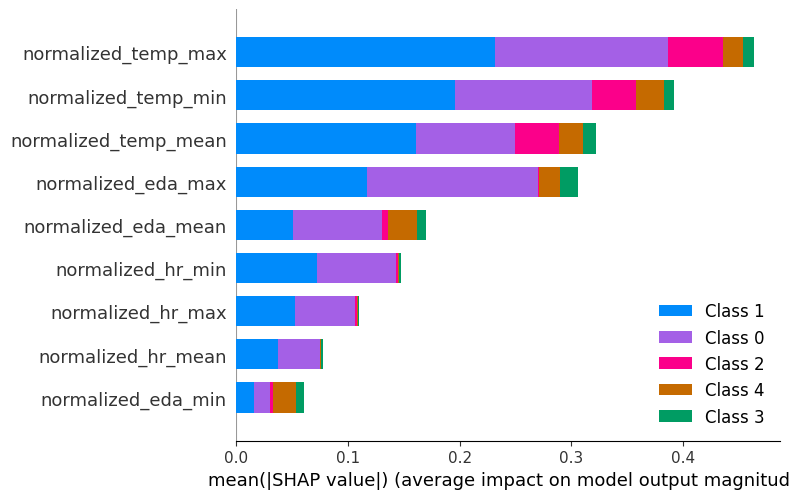

In [29]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, plot_type='bar')

### knn

In [30]:
auc_list = []
accuracy_list = []
f1score_list = []
recall_list = []

for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_knn = k_nearest_neighbors.predict(X)
    f1score = f1_score(y, y_pred_knn, average='macro')
    recall = recall_score(y, y_pred_knn, average='macro')
    accuracy = accuracy_score(y, y_pred_knn)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    auc_list.append(AUC)
    accuracy_list.append(accuracy)
    f1score_list.append(f1score)
    recall_list.append(recall)

    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)

mean_auc_kn = sum(auc_list) / len(auc_list)
mean_accuracy_kn = sum(accuracy_list) / len(accuracy_list)
mean_f1score_kn = sum(f1score_list) / len(f1score_list)
mean_recall_kn = sum(recall_list) / len(recall_list)



 Dataset: dfs2
auc = 0.5151953741738355
acc = 0.2280282044824981
f1 = 0.1449718932271763
recall = 0.2070540163914119

 Dataset: dfs3
auc = 0.44503363796759593
acc = 0.2294044665012407
f1 = 0.16367826874512809
recall = 0.29219239480545883

 Dataset: dfs4
auc = 0.4859918658095198
acc = 0.14304156984249936
f1 = 0.07143776494404405
recall = 0.21166905786704926

 Dataset: dfs5
auc = 0.5925117674821595
acc = 0.3143842474135054
f1 = 0.1529238440169418
recall = 0.2290396817197426

 Dataset: dfs6
auc = 0.5613536221371194
acc = 0.18044899119067917
f1 = 0.10468375280747391
recall = 0.13200486606997303

 Dataset: dfs7
auc = 0.5
acc = 0.41018038052878675
f1 = 0.20274804493900406
recall = 0.28607564020281717

 Dataset: dfs8
auc = 0.49806987187802854
acc = 0.27893654524089306
f1 = 0.12926545120835703
recall = 0.23048861308591398

 Dataset: dfs9
auc = 0.5801334752280782
acc = 0.2440863394441159
f1 = 0.12930855789883142
recall = 0.15859781918948576

 Dataset: dfs10
auc = 0.5933305732461214
acc = 0.091

### logistic regression

In [31]:
auc_list = []
accuracy_list = []
f1score_list = []
recall_list = []

for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_lr = logistic_regression.predict(X)
    f1score = f1_score(y, y_pred_lr, average='macro')
    recall = recall_score(y, y_pred_lr, average='macro')
    accuracy = accuracy_score(y, y_pred_lr)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    auc_list.append(AUC)
    accuracy_list.append(accuracy)
    f1score_list.append(f1score)
    recall_list.append(recall)

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)

mean_auc_lr = sum(auc_list) / len(auc_list)
mean_accuracy_lr = sum(accuracy_list) / len(accuracy_list)
mean_f1score_lr = sum(f1score_list) / len(f1score_list)
mean_recall_lr = sum(recall_list) / len(recall_list)




 Dataset: dfs2
auc = 0.5151953741738355
acc = 0.4687736086628053
f1 = 0.1508265685905968
recall = 0.1880990887055271

 Dataset: dfs3
auc = 0.44503363796759593
acc = 0.5112903225806451
f1 = 0.17745023770382548
recall = 0.2138091264512904

 Dataset: dfs4
auc = 0.4859918658095198
acc = 0.5213013168086754
f1 = 0.150615441999254
recall = 0.19311334289813487

 Dataset: dfs5
auc = 0.5925117674821595
acc = 0.48748470352653245
f1 = 0.1391331957453564
recall = 0.18666666666666668

 Dataset: dfs6
auc = 0.5613536221371194
acc = 0.5849199583214928
f1 = 0.1570847112693971
recall = 0.19734739533397253

 Dataset: dfs7
auc = 0.5
acc = 0.42117617988633554
f1 = 0.1185429887855342
recall = 0.2

 Dataset: dfs8
auc = 0.49806987187802854
acc = 0.4049647473560517
f1 = 0.1263482048971008
recall = 0.17864275816363415

 Dataset: dfs9
auc = 0.5801334752280782
acc = 0.3710821998817268
f1 = 0.11853600944510034
recall = 0.17127260320709656

 Dataset: dfs10
auc = 0.5933305732461214
acc = 0.3921246923707957
f1 = 0.12

### neural network

In [32]:
auc_list = []
accuracy_list = []
f1score_list = []
recall_list = []

for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_nn = neural_network.predict(X)
    f1score = f1_score(y, y_pred_nn, average='macro')
    recall = recall_score(y, y_pred_nn, average='macro')
    accuracy = accuracy_score(y, y_pred_nn)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')
    
    auc_list.append(AUC)
    accuracy_list.append(accuracy)
    f1score_list.append(f1score)
    recall_list.append(recall)

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)

mean_auc_nn = sum(auc_list) / len(auc_list)
mean_accuracy_nn = sum(accuracy_list) / len(accuracy_list)
mean_f1score_nn = sum(f1score_list) / len(f1score_list)
mean_recall_nn = sum(recall_list) / len(recall_list)


 Dataset: dfs2
auc = 0.5151953741738355
acc = 0.2590027700831025
f1 = 0.11911150154228398
recall = 0.21371966989637775

 Dataset: dfs3
auc = 0.44503363796759593
acc = 0.2161290322580645
f1 = 0.09591793677178857
recall = 0.18360600781444297

 Dataset: dfs4
auc = 0.4859918658095198
acc = 0.1914536534985799
f1 = 0.08283056264435866
recall = 0.21233859397417504

 Dataset: dfs5
auc = 0.5925117674821595
acc = 0.22883524307486927
f1 = 0.09858421465860803
recall = 0.21780617678381256

 Dataset: dfs6
auc = 0.5613536221371194
acc = 0.2257270057781567
f1 = 0.10257594332313524
recall = 0.22828379674017257

 Dataset: dfs7
auc = 0.5
acc = 0.2793427230046948
f1 = 0.12011029857006839
recall = 0.22399530654150776

 Dataset: dfs8
auc = 0.49806987187802854
acc = 0.2777614571092832
f1 = 0.1274666693969572
recall = 0.23271026629714422

 Dataset: dfs9
auc = 0.5801334752280782
acc = 0.3076581904198699
f1 = 0.14375012547069432
recall = 0.2436028659160696

 Dataset: dfs10
auc = 0.5933305732461214
acc = 0.2748

### SVM

In [33]:
auc_list = []
accuracy_list = []
f1score_list = []
recall_list = []

for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_svm = support_vector_machine.predict(X)
    f1score = f1_score(y, y_pred_svm, average='macro')
    recall = recall_score(y, y_pred_svm, average='macro')
    accuracy = accuracy_score(y, y_pred_svm)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    auc_list.append(AUC)
    accuracy_list.append(accuracy)
    f1score_list.append(f1score)
    recall_list.append(recall)

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)

mean_auc_svm = sum(auc_list) / len(auc_list)
mean_accuracy_svm = sum(accuracy_list) / len(accuracy_list)
mean_f1score_svm = sum(f1score_list) / len(f1score_list)
mean_recall_svm = sum(recall_list) / len(recall_list)


 Dataset: dfs2
auc = 0.5151953741738355
acc = 0.35696298161672124
f1 = 0.14501984883914293
recall = 0.17430749346222496

 Dataset: dfs3
auc = 0.44503363796759593
acc = 0.5468982630272953
f1 = 0.2224754111967243
recall = 0.26424072405528076

 Dataset: dfs4
auc = 0.4859918658095198
acc = 0.4805060676478182
f1 = 0.14315384615384616
recall = 0.17800095648015304

 Dataset: dfs5
auc = 0.5925117674821595
acc = 0.22082545333185005
f1 = 0.08876845018206955
recall = 0.0870997081911163

 Dataset: dfs6
auc = 0.5613536221371194
acc = 0.2833191247513498
f1 = 0.10031863156129465
recall = 0.09558964525407479

 Dataset: dfs7
auc = 0.5
acc = 0.2222634049913516
f1 = 0.0747440448346077
recall = 0.19343796468121802

 Dataset: dfs8
auc = 0.49806987187802854
acc = 0.28363689776733253
f1 = 0.12597796290821892
recall = 0.1585062959392698

 Dataset: dfs9
auc = 0.5801334752280782
acc = 0.0702247191011236
f1 = 0.03428983937917344
recall = 0.032412146025247356

 Dataset: dfs10
auc = 0.5933305732461214
acc = 0.174

In [34]:
print("\nMédias das Métricas RF:")
print('Média AUC =', mean_auc_rf)
print('Média Accuracy =', mean_accuracy_rf)
print('Média F1 Score =', mean_f1score_rf)
print('Média Recall =', mean_recall_rf)


print("\nMédias das Métricas KNN:")
print('Média AUC =', mean_auc_kn)
print('Média Accuracy =', mean_accuracy_kn)
print('Média F1 Score =', mean_f1score_kn)
print('Média Recall =', mean_recall_kn)

print("\nMédias das Métricas LR:")
print('Média AUC =', mean_auc_lr)
print('Média Accuracy =', mean_accuracy_lr)
print('Média F1 Score =', mean_f1score_lr)
print('Média Recall =', mean_recall_lr)

print("\nMédias das Métricas NN:")
print('Média AUC =', mean_auc_nn)
print('Média Accuracy =', mean_accuracy_nn)
print('Média F1 Score =', mean_f1score_nn)
print('Média Recall =', mean_recall_nn)

print("\nMédias das Métricas SVM:")
print('\nMédia AUC =', mean_auc_svm)
print('Média Accuracy =', mean_accuracy_svm)
print('Média F1 Score =', mean_f1score_svm)
print('Média Recall =', mean_recall_svm)


Médias das Métricas RF:
Média AUC = 0.5316985829793847
Média Accuracy = 0.46455868189054733
Média F1 Score = 0.1901013819179949
Média Recall = 0.25650055381450504

Médias das Métricas KNN:
Média AUC = 0.5316985829793847
Média Accuracy = 0.24121648041993313
Média F1 Score = 0.12641435984373375
Média Recall = 0.190805804378174

Médias das Métricas LR:
Média AUC = 0.5316985829793847
Média Accuracy = 0.4482961607264118
Média F1 Score = 0.13506593139699424
Média Recall = 0.19070082966871407

Médias das Métricas NN:
Média AUC = 0.5316985829793847
Média Accuracy = 0.24886157068610787
Média F1 Score = 0.11013787568133766
Média Recall = 0.21509950158707508

Médias das Métricas SVM:

Média AUC = 0.5316985829793847
Média Accuracy = 0.2684321121729482
Média F1 Score = 0.10473964276873349
Média Recall = 0.1478729454172733


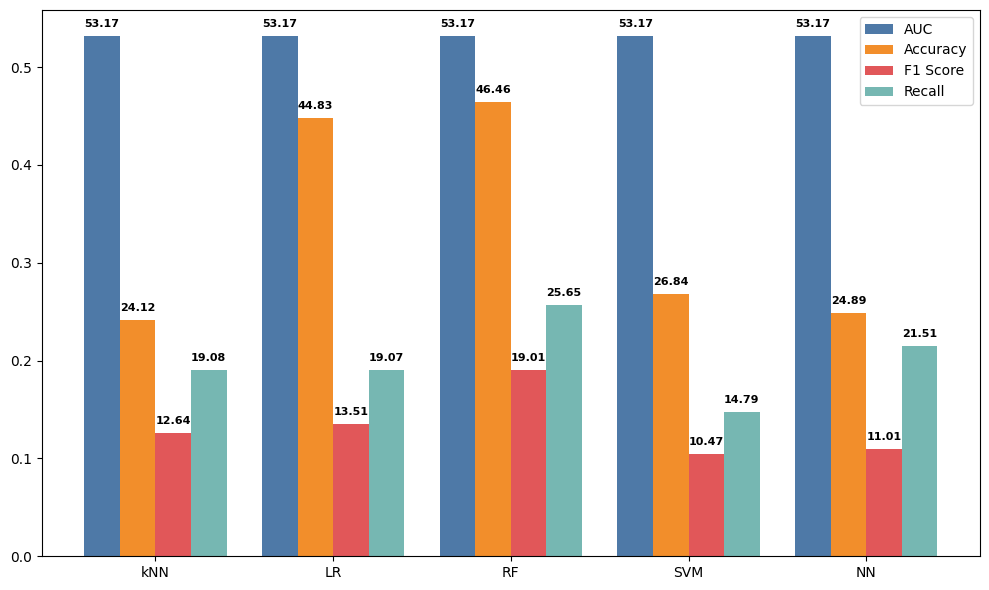

In [35]:
labels = ['kNN', 'LR', 'RF',  'SVM', 'NN']
auc_scores = [mean_auc_kn, mean_auc_lr, mean_auc_rf, mean_auc_svm, mean_auc_nn]
accuracy_scores = [ mean_accuracy_kn, mean_accuracy_lr, mean_accuracy_rf,mean_accuracy_svm, mean_accuracy_nn]
f1_scores = [ mean_f1score_kn, mean_f1score_lr, mean_f1score_rf,mean_f1score_svm, mean_f1score_nn]
recall_scores = [ mean_recall_kn, mean_recall_lr,mean_recall_rf, mean_recall_svm, mean_recall_nn]

# Define colors with a more appealing palette
colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2']

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(labels))
width = 0.2  # Bar width

# Create bars with new colors
bars1 = ax.bar(x - 1.5*width, auc_scores, width, label='AUC', color=colors[0])
bars2 = ax.bar(x - 0.5*width, accuracy_scores, width, label='Accuracy', color=colors[1])
bars3 = ax.bar(x + 0.5*width, f1_scores, width, label='F1 Score', color=colors[2])
bars4 = ax.bar(x + 1.5*width, recall_scores, width, label='Recall', color=colors[3])

# Function to add text labels above bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height*100:.2f}',  # Convert to percentage
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # Offset the text slightly above the bar
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8, fontweight='bold')

# Add labels to all bars
for bars in [bars1, bars2, bars3, bars4]:
    add_labels(bars)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

## teste e treino em datasets individuais

In [36]:
mean_auc = []
mean_acc = []
mean_f1 = []
mean_recall = []

for i in range(2, 18):
    if i == 12:
        continue

    dataset = globals()[f'dfs{i}']
    train_set = dataset.drop(columns='label_mean') 
    labels = np.array(dataset['label_mean'], dtype=int)

    X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.3, random_state=30)
    
    if len(y_train.shape) > 1:
        y_train = y_train.flatten()

    k_nearest_neighbors = KNeighborsClassifier(n_neighbors=5, metric="minkowski", weights="uniform")
    k_nearest_neighbors.fit(X_train, y_train.ravel())
    y_pred_knn = k_nearest_neighbors.predict(X_test)
    f1score_knn = f1_score(y_test, y_pred_knn, average='macro')
    recall_knn = recall_score(y_test, y_pred_knn, average='macro')
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    AUC_knn = roc_auc_score(y_test.ravel(), k_nearest_neighbors.predict_proba(X_test), multi_class='ovr')
    
    mean_f1.append(f1score_knn)
    mean_recall.append(recall_knn)
    mean_acc.append(accuracy_knn)
    mean_auc.append(AUC_knn)

final_metrics_knn = {
    'mean_auc': sum(mean_auc) / len(mean_auc),
    'mean_acc': sum(mean_acc) / len(mean_acc),
    'mean_f1': sum(mean_f1) / len(mean_f1),
    'mean_recall': sum(mean_recall) / len(mean_recall)
}

In [37]:
mean_auc_lr = []
mean_acc_lr = []
mean_f1_lr = []
mean_recall_lr = []

for i in range(2, 18):
    if i == 12:  
        continue
    
    dataset = globals()[f'dfs{i}']
    train_set = dataset.drop(columns='label_mean')
    labels = np.array(dataset['label_mean'], dtype=int)
    X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.3, random_state=30)

    logistic_regression = LogisticRegression(penalty="l2", C=1.0, max_iter=999)
    logistic_regression.fit(X_train, y_train.ravel())
    y_pred_lr = logistic_regression.predict(X_test)

    f1score_lr = f1_score(y_test, y_pred_lr, average='macro')
    recall_lr = recall_score(y_test, y_pred_lr, average='macro')
    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    AUC_lr = roc_auc_score(y_test.ravel(), logistic_regression.predict_proba(X_test), multi_class='ovr')
    mean_f1_lr.append(f1score_lr)
    mean_recall_lr.append(recall_lr)
    mean_acc_lr.append(accuracy_lr)
    mean_auc_lr.append(AUC_lr)

final_metrics_lr = {
    'mean_auc': sum(mean_auc_lr) / len(mean_auc_lr),
    'mean_acc': sum(mean_acc_lr) / len(mean_acc_lr),
    'mean_f1': sum(mean_f1_lr) / len(mean_f1_lr),
    'mean_recall': sum(mean_recall_lr) / len(mean_recall_lr)
}



In [38]:
mean_auc_rf = []
mean_acc_rf = []
mean_f1_rf = []
mean_recall_rf = []

for i in range(2, 18):
    if i == 12:
        continue

    dataset = globals()[f'dfs{i}']
    train_set = dataset.drop(columns='label_mean')
    labels = np.array(dataset['label_mean'], dtype=int)
    X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.3, random_state=30)
    
    clf = RandomForestClassifier(n_estimators=100, max_depth=15)
    clf.fit(X_train, y_train.ravel())
    y_pred_rf = clf.predict(X_test)
    f1score_rf = f1_score(y_test, y_pred_rf, average='macro')
    recall_rf = recall_score(y_test, y_pred_rf, average='macro')
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    AUC_rf = roc_auc_score(y_test.ravel(), clf.predict_proba(X_test), multi_class='ovr')
    mean_f1_rf.append(f1score_rf)
    mean_recall_rf.append(recall_rf)
    mean_acc_rf.append(accuracy_rf)
    mean_auc_rf.append(AUC_rf)

final_metrics_rf = {
    'mean_auc': sum(mean_auc_rf) / len(mean_auc_rf),
    'mean_acc': sum(mean_acc_rf) / len(mean_acc_rf),
    'mean_f1': sum(mean_f1_rf) / len(mean_f1_rf),
    'mean_recall': sum(mean_recall_rf) / len(mean_recall_rf)
}


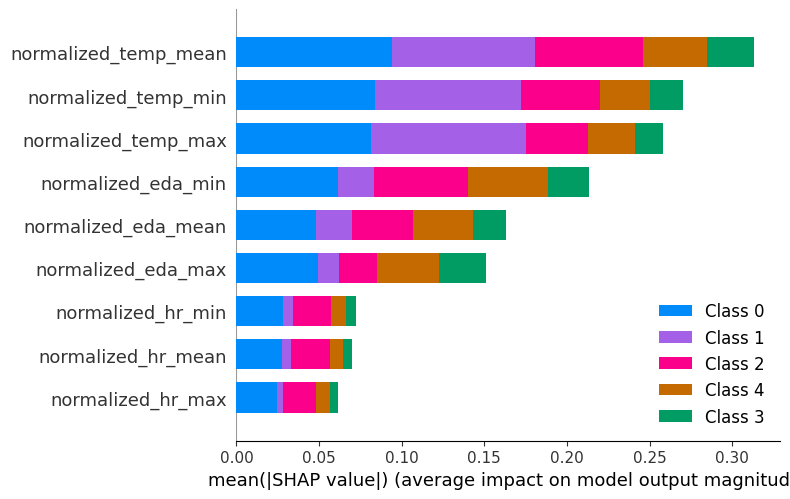

In [39]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type='bar')


In [40]:
mean_auc_nn = []
mean_acc_nn = []
mean_f1_nn = []
mean_recall_nn = []

for i in range(2, 18):
    if i == 12:
        continue
    
    dataset = globals()[f'dfs{i}']
    train_set = dataset.drop(columns='label_mean')
    labels = np.array(dataset['label_mean'], dtype=int)
    X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.3, random_state=30)

    neural_network = MLPClassifier(hidden_layer_sizes=(100,), activation="relu", solver="adam", max_iter=999)
    neural_network.fit(X_train, y_train.ravel())
    y_pred_nn = neural_network.predict(X_test)

    f1score_nn = f1_score(y_test, y_pred_nn, average='macro')
    recall_nn = recall_score(y_test, y_pred_nn, average='macro')
    accuracy_nn = accuracy_score(y_test, y_pred_nn)
    AUC_nn = roc_auc_score(y_test.ravel(), neural_network.predict_proba(X_test), multi_class='ovr')
    mean_f1_nn.append(f1score_nn)
    mean_recall_nn.append(recall_nn)
    mean_acc_nn.append(accuracy_nn)
    mean_auc_nn.append(AUC_nn)

final_metrics_nn = {
    'mean_auc': sum(mean_auc_nn) / len(mean_auc_nn),
    'mean_acc': sum(mean_acc_nn) / len(mean_acc_nn),
    'mean_f1': sum(mean_f1_nn) / len(mean_f1_nn),
    'mean_recall': sum(mean_recall_nn) / len(mean_recall_nn)
}


Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.


In [41]:
mean_auc_svm = []
mean_acc_svm = []
mean_f1_svm = []
mean_recall_svm = []

for i in range(2, 18):
    if i == 12:  
        continue

    dataset = globals()[f'dfs{i}']
    train_set = dataset.drop(columns='label_mean')
    labels = np.array(dataset['label_mean'], dtype=int)
    X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.3, random_state=30)

    support_vector_machine = SVC(C=1.0, gamma=0.1, kernel="linear", tol=0.001, max_iter=9999, probability=True)
    support_vector_machine.fit(X_train, y_train.ravel())
    y_pred_svm = support_vector_machine.predict(X_test)
    
    f1score_svm = f1_score(y_test, y_pred_svm, average='macro')
    recall_svm = recall_score(y_test, y_pred_svm, average='macro')
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    AUC_svm = roc_auc_score(y_test.ravel(), support_vector_machine.predict_proba(X_test), multi_class='ovr')
    mean_f1_svm.append(f1score_svm)
    mean_recall_svm.append(recall_svm)
    mean_acc_svm.append(accuracy_svm)
    mean_auc_svm.append(AUC_svm)

final_metrics_svm = {
    'mean_auc': sum(mean_auc_svm) / len(mean_auc_svm),
    'mean_acc': sum(mean_acc_svm) / len(mean_acc_svm),
    'mean_f1': sum(mean_f1_svm) / len(mean_f1_svm),
    'mean_recall': sum(mean_recall_svm) / len(mean_recall_svm)
}


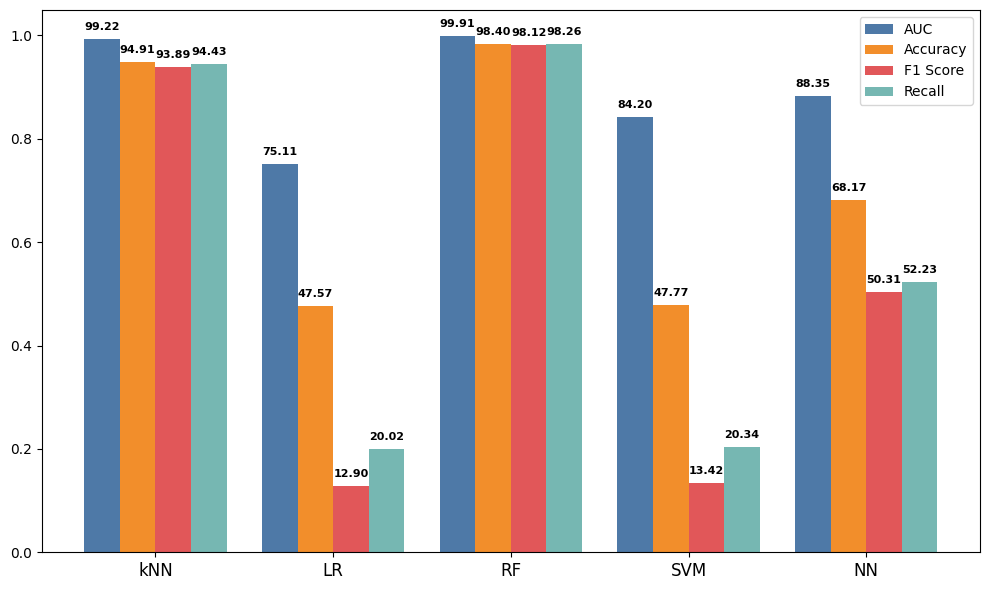

In [42]:
labels = ['kNN', 'LR', 'RF', 'SVM', 'NN']

auc_scores = [final_metrics_knn['mean_auc'], final_metrics_lr['mean_auc'], final_metrics_rf['mean_auc'], final_metrics_svm['mean_auc'], final_metrics_nn['mean_auc']]
accuracy_scores = [final_metrics_knn['mean_acc'], final_metrics_lr['mean_acc'], final_metrics_rf['mean_acc'], final_metrics_svm['mean_acc'], final_metrics_nn['mean_acc']]
f1_scores = [final_metrics_knn['mean_f1'], final_metrics_lr['mean_f1'], final_metrics_rf['mean_f1'], final_metrics_svm['mean_f1'], final_metrics_nn['mean_f1']]
recall_scores = [final_metrics_knn['mean_recall'], final_metrics_lr['mean_recall'], final_metrics_rf['mean_recall'], final_metrics_svm['mean_recall'], final_metrics_nn['mean_recall']]

# Define colors with a more appealing palette
colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2']

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(labels))
width = 0.2  # Bar width

# Create bars with new colors
bars1 = ax.bar(x - 1.5*width, auc_scores, width, label='AUC', color=colors[0])
bars2 = ax.bar(x - 0.5*width, accuracy_scores, width, label='Accuracy', color=colors[1])
bars3 = ax.bar(x + 0.5*width, f1_scores, width, label='F1 Score', color=colors[2])
bars4 = ax.bar(x + 1.5*width, recall_scores, width, label='Recall', color=colors[3])

# Function to add text labels above bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height*100:.2f}',  # Convert to percentage
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # Offset the text slightly above the bar
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8, fontweight="bold")

for bars in [bars1, bars2, bars3, bars4]:
    add_labels(bars)

ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend()

plt.tight_layout()
plt.show()

## rf com diferentes porcentagem no dataset geral

#### 10%

In [43]:
train_set = df_normalizado
labels = np.array(label_stats, dtype=int)
X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.1, random_state=30)
clf = RandomForestClassifier(n_estimators=100,max_depth=15)
clf.fit(X_train, y_train.ravel())
y_pred_rf = clf.predict(X_test)

f1score   = f1_score        (y_test, y_pred_rf, average = 'macro')
recall    = recall_score    (y_test, y_pred_rf, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_rf)
AUC       = roc_auc_score   (y_test.ravel(), clf.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.9988060582074396
acc = 0.9748201438848921
f1 = 0.9723090045566007
recall = 0.9723596375326963


#### 20%

In [44]:
train_set = df_normalizado
labels = np.array(label_stats, dtype=int)
X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.2, random_state=30)
clf = RandomForestClassifier(n_estimators=100,max_depth=15)
clf.fit(X_train, y_train.ravel())
y_pred_rf = clf.predict(X_test)

f1score   = f1_score        (y_test, y_pred_rf, average = 'macro')
recall    = recall_score    (y_test, y_pred_rf, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_rf)
AUC       = roc_auc_score   (y_test.ravel(), clf.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.999014952441077
acc = 0.9754196642685852
f1 = 0.9721734167756718
recall = 0.9696344095336119


#### 30%

In [45]:
train_set = df_normalizado
labels = np.array(label_stats, dtype=int)
X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.3, random_state=30)
clf = RandomForestClassifier(n_estimators=100,max_depth=15)
clf.fit(X_train, y_train.ravel())
y_pred_rf = clf.predict(X_test)

f1score   = f1_score        (y_test, y_pred_rf, average = 'macro')
recall    = recall_score    (y_test, y_pred_rf, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_rf)
AUC       = roc_auc_score   (y_test.ravel(), clf.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.998494894316359
acc = 0.978017585931255
f1 = 0.9766281257923083
recall = 0.9751065966330528


#### 40%

In [46]:
train_set = df_normalizado
labels = np.array(label_stats, dtype=int)
X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.4, random_state=30)
clf = RandomForestClassifier(n_estimators=100,max_depth=15)
clf.fit(X_train, y_train.ravel())
y_pred_rf = clf.predict(X_test)

f1score   = f1_score        (y_test, y_pred_rf, average = 'macro')
recall    = recall_score    (y_test, y_pred_rf, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_rf)
AUC       = roc_auc_score   (y_test.ravel(), clf.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.9978462129279301
acc = 0.9757194244604317
f1 = 0.9725750485609771
recall = 0.9690103498221436


#### 50%

In [47]:
train_set = df_normalizado
labels = np.array(label_stats, dtype=int)
X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.5, random_state=30)
clf = RandomForestClassifier(n_estimators=100,max_depth=15)
clf.fit(X_train, y_train.ravel())
y_pred_rf = clf.predict(X_test)

f1score   = f1_score        (y_test, y_pred_rf, average = 'macro')
recall    = recall_score    (y_test, y_pred_rf, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_rf)
AUC       = roc_auc_score   (y_test.ravel(), clf.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.9975596921836924
acc = 0.9702566562724874
f1 = 0.9680229569784892
recall = 0.9663143556980591
